### What the lady (Sandra?) asked
- benchmark: K-means
- innitialization: random vs k-means
- modalities: T1-w vs T1-w+FLAIR
- metrics: DSC, num iterations, comp.time

# Still to do:
 - Fix label matching between gt and predictions
 - Boxplots and tables:
    - One for iterations: four bxplts t1_km, t1_em, t1_t2_km, t1_t2_em
    - One for time: four bxplts t1_km, t1_em, t1_t2_km, t1_t2_em
    - One for dice: four bxplts t1_km, t1_em, t1_t2_km, t1_t2_em
 - Boxplots and tables:
    - One for iterations: four bxplts t1_em_kminit, t1_t2_em_kminit, t1_em_random, t1_t2_em_random
    - One for time: four bxplts t1_em_kminit, t1_t2_em_kminit, t1_em_random, t1_t2_em_random
    - One for dice: four bxplts t1_em_kminit, t1_t2_em_kminit, t1_em_random, t1_t2_em_random

In [1]:
import utils
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
from pathlib import Path
from sklearn.cluster import KMeans
from src import ExpectationMaximization
from scipy.ndimage import median_filter
import seaborn as sns
from varname import nameof
from typing import List

In [2]:
a = np.ones((20, 2))
b = np.ones((20, 2))+2

(a * b).sum(axis=1)

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6.])

In [3]:
def brain_tissue_segmentation(t1, t2, brain_mask, mode, mean_init='kmeans'):
    # T1+T2
    t1_vector = t1[brain_mask == 255].flatten()
    t2_vector = t2[brain_mask == 255].flatten()
    data = np.array([t1_vector, t2_vector]).T
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init=mean_init,
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=True, use_our_gauss_likelihood=False)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1_t2 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_t2_seg_res = predictions.reshape(t1.shape)
    # T1
    data = np.array(t1_vector)[:, np.newaxis]
    if mode == 'em':
        model = ExpectationMaximization(
            n_components=3, mean_init=mean_init,
            priors='non_informative', verbose=False, plot_rate=None,
            hard_em=True, use_our_gauss_likelihood=False)
    else:
        model = KMeans(n_clusters=3, random_state=420)
    start = time.time()
    preds = model.fit_predict(data)
    t_t1 = time.time() - start
    predictions = brain_mask.flatten()
    predictions[predictions==255] = preds + 1
    t1_seg_res = predictions.reshape(t1.shape)
    return t1_seg_res, t1_t2_seg_res, t_t1, t_t1_t2


def dice_score(gt, pred):
    classes = np.unique(gt[gt != 0])
    dice = np.zeros((len(classes)))
    for i in classes:
        bin_pred = np.where(pred == i, 1, 0)
        bin_gt = np.where(gt == i, 1, 0)
        dice[i-1] = np.sum(bin_pred[bin_gt == 1]) * 2.0 / (np.sum(bin_pred) + np.sum(bin_gt))
    return dice.tolist()


def plots(t1_array, t2_array,  t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt, slice_n = 20):
    plt.figure(figsize=(20, 5))
    plt.subplot(171)
    plt.title('T1')
    plt.imshow(t1_array[slice_n, :, :], cmap='gray')
    plt.axis('off')
    plt.subplot(172)
    plt.title('T2')
    plt.imshow(t2_array[slice_n, :, :], cmap='gray')
    plt.axis('off')
    
    plt.subplot(173)
    plt.title('EM T1')
    plt.imshow(t1_seg_res_em[slice_n, :, :])
    plt.axis('off')
    plt.subplot(174)
    plt.title('KMeans T1')
    plt.imshow(t1_seg_res_km[slice_n, :, :])
    plt.axis('off')
    plt.subplot(175)
    plt.title('EM T1+T2')
    plt.imshow(t1_t2_seg_res_em[slice_n, :, :])
    plt.axis('off')
    plt.subplot(176)
    plt.title('KMeans T1+T2')
    plt.imshow(t1_t2_seg_res_km[slice_n, :, :])
    plt.axis('off')
    
    plt.subplot(177)
    plt.title('GT')
    plt.imshow(gt[slice_n, :, :])
    plt.axis('off')
    plt.show()
    
    
def save_segementations(volume, reference, filepath):
    # Save image
    img = sitk.GetImageFromArray(volume)
    img.SetDirection(reference.GetDirection())
    img.SetOrigin(reference.GetOrigin())
    img.SetSpacing(reference.GetSpacing())
    sitk.WriteImage(img, filepath)

-------------------- Subject N°1 --------------------


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]
/home/jseia/anaconda3/envs/misa/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jseia/anaconda3/envs/misa/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


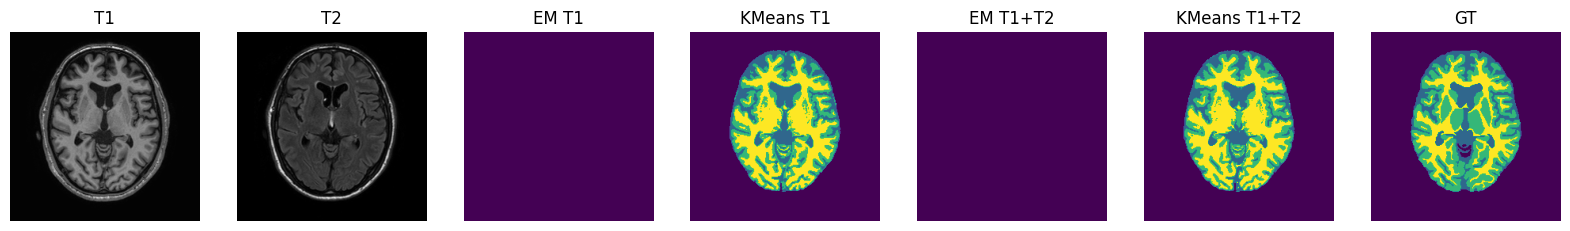

-------------------- Subject N°2 --------------------


  9%|▉         | 9/100 [00:02<00:27,  3.30it/s]

In [4]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em, t1_t2_seg_res_em, t_t1_em, t_t1_t2_em = brain_tissue_segmentation(t1_array, t2_array, bm, 'em')
    t1_seg_res_km, t1_t2_seg_res_km, t_t1_km, t_t1_t2_km = brain_tissue_segmentation(t1_array, t2_array, bm, 'km')

    # Correct labels to match groun truth
    t1_seg_res_em = utils.match_pred_w_gt(t1_seg_res_em, gt_array, t1_array)
    t1_t2_seg_res_em = utils.match_pred_w_gt(t1_t2_seg_res_em, gt_array, t1_array, t2_array)
    t1_seg_res_km = utils.match_pred_w_gt(t1_seg_res_km, gt_array, t1_array)
    t1_t2_seg_res_km = utils.match_pred_w_gt(t1_t2_seg_res_km, gt_array, t1_array, t2_array)
    spm_seg_t1_t2_array = utils.match_pred_w_gt(spm_seg_t1_t2_array, gt_array, t1_array, t2_array)
    spm_seg_t1_array = utils.match_pred_w_gt(spm_seg_t1_array, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(dice_score(gt_array, t1_seg_res_km) + ['T1', i, 'KM', t_t1_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_km) + ['T1+T2', i, 'KM', t_t1_t2_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em) + ['T1', i, 'EM', t_t1_em])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em) + ['T1+T2', i, 'EM', t_t1_t2_em])
    dice_scores.append(dice_score(gt_array, spm_seg_t1_array) + ['T1', i, 'SPM', 0])
    dice_scores.append(dice_score(gt_array, spm_seg_t1_t2_array) + ['T1+T2', i, 'SPM', 0])
    
    # Plot
    plots(t1_array, t2_array, t1_seg_res_em, t1_seg_res_km, t1_t2_seg_res_em, t1_t2_seg_res_km, gt_array, slice_n = 20)
    
    # break
    # Save images
    save_segementations(t1_seg_res_em, spm_seg_t1_t2, data_path / f'{i+1}/em_seg_t1.nii')
    save_segementations(t1_seg_res_km, spm_seg_t1_t2, data_path / f'{i+1}/km_seg_t1.nii')
    save_segementations(t1_t2_seg_res_em, spm_seg_t1_t2, data_path / f'{i+1}/em_seg_t1_t2.nii')
    save_segementations(t1_t2_seg_res_km, spm_seg_t1_t2, data_path / f'{i+1}/km_seg_t1_t2.nii')

dice_scores = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'time'])
# dice_scores.to_csv('dice_scores.csv')
dice_scores

# Make complete results figure

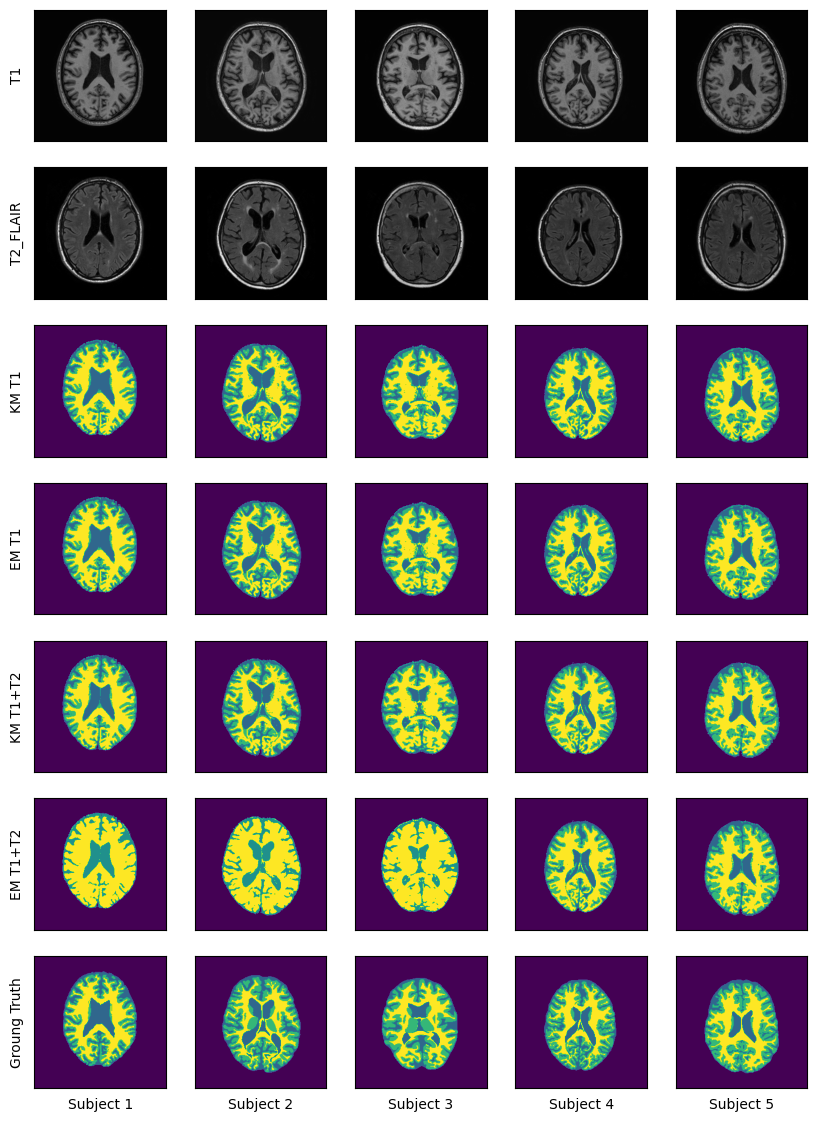

In [ ]:
# img_names = [
#     'T1.nii', 'T2_FLAIR.nii', 'km_seg_t1.nii', 'em_seg_t1.nii', 'spm_seg_t1.nii',
#     'km_seg_t1_t2.nii', 'em_seg_t1_t2.nii', 'spm_seg_t1_t2.nii', 'LabelsForTesting.nii'
# ]
img_names = [
    'T1.nii', 'T2_FLAIR.nii', 'km_seg_t1.nii', 'em_seg_t1.nii',
    'km_seg_t1_t2.nii', 'em_seg_t1_t2.nii', 'LabelsForTesting.nii'
]   
# ylabels = [
#     'T1', 'T2_FLAIR', 'KM T1', 'EM T1', 'SPM T1',
#     'KM T1+T2', 'EM T1+T2', 'SPM T1+T2', 'Groung Truth'
# ]
ylabels = [
    'T1', 'T2_FLAIR', 'KM T1', 'EM T1',
    'KM T1+T2', 'EM T1+T2', 'Groung Truth'
]


slice_n = 25
fig, ax = plt.subplots(len(img_names), 5, figsize=(10, 14))
for i in range(5):
    # Load images
    
    for j, img_name in enumerate(img_names):
        img = sitk.ReadImage(data_path / f'{i+1}/{img_name}')
        img_array = sitk.GetArrayFromImage(img)
        if j == len(img_names)-1:
            ax[j, i].set_xlabel(f'Subject {i+1}')
        if j in [0, 1]:
            ax[j, i].imshow(img_array[slice_n, :, :], cmap='gray')
        else:
            ax[j, i].imshow(img_array[slice_n, :, :])
        ax[j, i].set_xticks([]) 
        ax[j, i].set_yticks([]) 
        if i == 0:
            ax[j, i].set_ylabel(ylabels[j])

In [ ]:
df = pd.melt(dice_scores, id_vars=['modalities', 'subject', 'model'], value_vars=['CSF', 'GM', 'WM'], ignore_index=False)
df['model'] = df['model'].str.upper()
df.columns = ['Modalities', 'Subject', 'Model', 'Tissue', 'Dice']

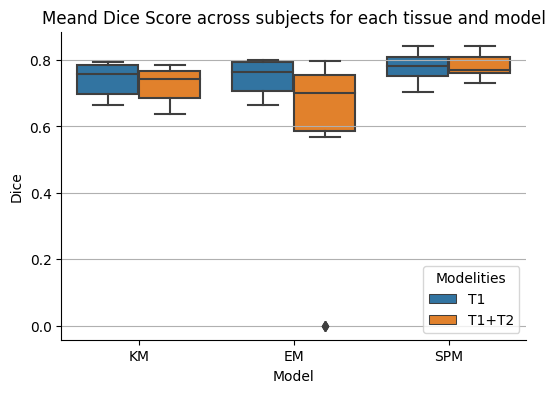

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Meand Dice Score across subjects for each tissue and model')
sns.boxplot(data=df, x="Model", y="Dice", hue="Modalities")
sns.despine()
plt.grid(axis='y')
plt.legend(loc='lower right', title='Modelities')
plt.show()

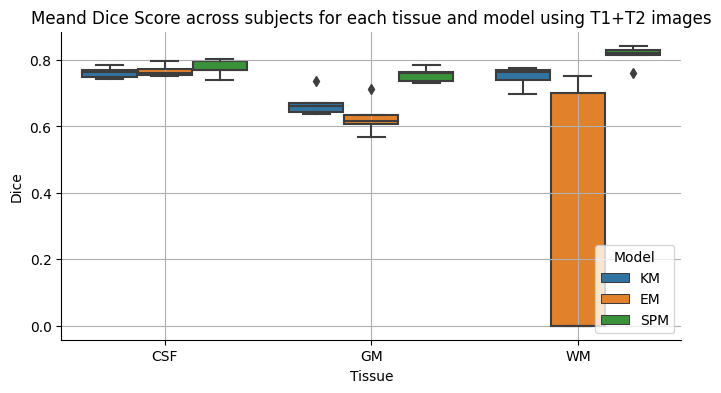

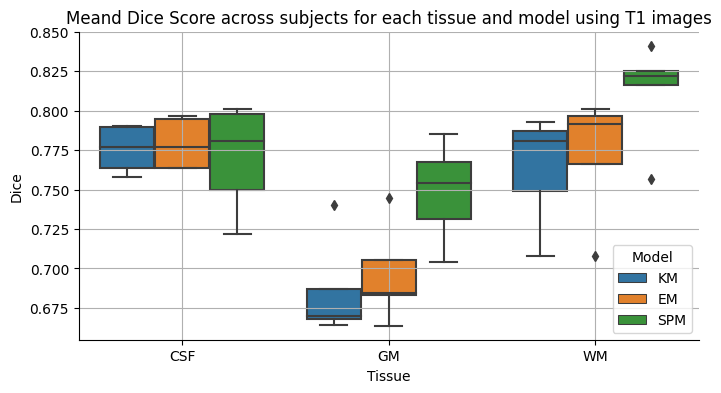

In [ ]:
df_ = df.loc[df.Modalities == 'T1+T2']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1+T2 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Model')
plt.show()

df_ = df.loc[df.Modalities == 'T1']
plt.figure(figsize=(8,4))
plt.title('Meand Dice Score across subjects for each tissue and model using T1 images')
sns.boxplot(data=df_, x="Tissue", y="Dice", hue="Model")
sns.despine()
plt.grid('h')
plt.legend(loc='lower right', title='Model')
plt.show()

# Compare initializations

In [ ]:
data_path = Path.cwd().parent / 'data/P2_data'

dice_scores = []
for i in range(5):
    print(f'{"-"*20} Subject N°{i + 1} {"-"*20}')
    
    # Load images
    t1 = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2 = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    bm = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')
    spm_seg_t1_t2 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1_t2.nii')
    spm_seg_t1 = sitk.ReadImage(data_path / f'{i+1}/spm_seg_t1.nii')

    # Get arrays
    t1_array = sitk.GetArrayFromImage(t1)
    t2_array = sitk.GetArrayFromImage(t2)
    gt_array = sitk.GetArrayFromImage(gt)
    bm = sitk.GetArrayFromImage(bm)
    spm_seg_t1_t2_array = sitk.GetArrayFromImage(spm_seg_t1_t2)
    spm_seg_t1_array = sitk.GetArrayFromImage(spm_seg_t1)

    # Cast images de uint8
    t1_array = utils.min_max_norm(t1_array, 255, 'uint8')
    t2_array = utils.min_max_norm(t2_array, 255, 'uint8')

    # Segement Brain
    t1_seg_res_em_km, t1_t2_seg_res_em_km, t_t1_em_km, t_t1_t2_em_km = brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'kmeans')
    t1_seg_res_em_rm, t1_t2_seg_res_em_rm, t_t1_em_rm, t_t1_t2_em_rm = brain_tissue_segmentation(t1_array, t2_array, bm, 'em', 'random')

    # Correct labels to match groun truth
    t1_seg_res_em_km = utils.match_pred_w_gt(t1_seg_res_em_km, gt_array, t1_array)
    t1_t2_seg_res_em_km = utils.match_pred_w_gt(t1_t2_seg_res_em_km, gt_array, t1_array, t2_array)
    t1_seg_res_em_rm = utils.match_pred_w_gt(t1_seg_res_em_rm, gt_array, t1_array)
    t1_t2_seg_res_em_rm = utils.match_pred_w_gt(t1_t2_seg_res_em_rm, gt_array, t1_array, t2_array)
    spm_seg_t1_t2_array = utils.match_pred_w_gt(spm_seg_t1_t2_array, gt_array, t1_array, t2_array)
    spm_seg_t1_array = utils.match_pred_w_gt(spm_seg_t1_array, gt_array, t1_array, t2_array)

    # Get dice scores
    dice_scores.append(dice_score(gt_array, t1_seg_res_em_km) + ['T1', i, 'EM-kmeans', t_t1_em_km])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em_km) + ['T1+T2', i, 'EM-kmeans', t_t1_t2_em_km])
    dice_scores.append(dice_score(gt_array, t1_seg_res_em_rm) + ['T1', i, 'EM-random', t_t1_em_rm])
    dice_scores.append(dice_score(gt_array, t1_t2_seg_res_em_rm) + ['T1+T2', i, 'EM-random', t_t1_t2_em_rm])
    dice_scores.append(dice_score(gt_array, spm_seg_t1_array) + ['T1', i, 'SPM', 0])
    dice_scores.append(dice_score(gt_array, spm_seg_t1_t2_array) + ['T1+T2', i, 'SPM', 0])
    
    # Plot
    plots(t1_array, t2_array, t1_seg_res_em_km, t1_seg_res_em_rm, t1_t2_seg_res_em_km, t1_t2_seg_res_em_rm, gt_array, slice_n = 20)
    
    # break
    # Save images
    save_segementations(t1_seg_res_em_km, spm_seg_t1_t2, data_path / f'{i+1}/em_km_seg_t1.nii')
    save_segementations(t1_seg_res_em_rm, spm_seg_t1_t2, data_path / f'{i+1}/em_rm_seg_t1.nii')
    save_segementations(t1_t2_seg_res_em_km, spm_seg_t1_t2, data_path / f'{i+1}/em_km_seg_t1_t2.nii')
    save_segementations(t1_t2_seg_res_em_rm, spm_seg_t1_t2, data_path / f'{i+1}/em_rm_seg_t1_t2.nii')

dice_scores_init = pd.DataFrame(data=dice_scores, columns = ['CSF', 'GM', 'WM', 'modalities', 'subject', 'model', 'time'])
dice_scores_init.to_csv('dice_scores_init.csv')
dice_scores_init

-------------------- Subject N°1 --------------------


  0%|          | 0/100 [00:00<?, ?it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


  1%|          | 1/100 [00:00<00:35,  2.81it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


  2%|▏         | 2/100 [00:00<00:33,  2.95it/s]

(523608,)
(523608,)


  3%|▎         | 3/100 [00:01<00:35,  2.77it/s]

(523608,)
(523608, 3)
(523608,)


  4%|▍         | 4/100 [00:01<00:31,  3.04it/s]

(523608,)
(523608,)
(523608, 3)
(523608,)
(523608,)
(523608,)
(523608, 3)


  5%|▌         | 5/100 [00:01<00:31,  3.03it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


  6%|▌         | 6/100 [00:01<00:29,  3.16it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


  7%|▋         | 7/100 [00:02<00:28,  3.21it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


  8%|▊         | 8/100 [00:02<00:29,  3.13it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


  9%|▉         | 9/100 [00:02<00:28,  3.25it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


 10%|█         | 10/100 [00:03<00:28,  3.18it/s]

(523608,)
(523608,)
(523608,)


 11%|█         | 11/100 [00:03<00:29,  3.03it/s]

(523608, 3)
(523608,)


 12%|█▏        | 12/100 [00:03<00:30,  2.91it/s]

(523608,)
(523608,)
(523608, 3)
(523608,)
(523608,)
(523608,)
(523608, 3)


 13%|█▎        | 13/100 [00:04<00:29,  2.94it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


 14%|█▍        | 14/100 [00:04<00:28,  3.02it/s]

(523608,)
(523608,)
(523608,)


 15%|█▌        | 15/100 [00:04<00:28,  3.01it/s]

(523608, 3)
(523608,)


 16%|█▌        | 16/100 [00:05<00:27,  3.09it/s]

(523608,)
(523608,)
(523608, 3)
(523608,)
(523608,)
(523608,)
(523608, 3)


 17%|█▋        | 17/100 [00:05<00:27,  3.07it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


 18%|█▊        | 18/100 [00:05<00:25,  3.16it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


 19%|█▉        | 19/100 [00:06<00:25,  3.17it/s]

(523608,)
(523608,)
(523608,)
(523608, 3)


 20%|██        | 20/100 [00:06<00:25,  3.13it/s]